# Stereo vision

## Preliminaries

The following image shows the main concept underlying stereo vision, i.e., triangulation.

![Stereo vision setup.](stereo_setup.png)

<center><small>Basic concept behind stereo vision - drawing inspired by the drawing in the [lecture by Robert Collins](http://www.cse.psu.edu/~rtc12/CSE486/lecture09.pdf)</small></center>

The left camera is situated at the world coordinate $(0,0,0)$, while the right camera is situated at $(T_X, 0, 0)$. Both cameras observe points in the world, such as the point represented by a red star, situated at the world coordinate $(X,Y,Z)$. The figure shows the image planes in front of the camera, and the assumption is made that they are perfect, linear, pinhole cameras. That means that distortion of the image has been removed, and projection of real-world points are linear:

$(x_l, y_l) = (f \frac{X}{Z}, f \frac{Y}{Z})$, and $(x_r, y_r) = (f \frac{(X-T_X)}{Z}, f \frac{Y}{Z})$,

where $f$ is the focal length, and $T_X$ the translation between the cameras. Please note that, since the cameras are only displaced in the $X$-axis, the image $y$-coordinates are equal (i.e., the standard stereo setup involves [horizontal epipolar lines](https://en.wikipedia.org/wiki/Epipolar_geometry)). 

The x-coordinates can be different though, leading to a non-zero _disparity_ $d$:

$d = x_l – x_r = f \frac{X}{Z} – f\frac{(X-T_X)}{Z} = f \frac{T_X}{Z}$

Matching a feature present in the left image to the same feature in the right image allows one to determine the disparity and subsequently the "depth" of the feature along the $Z$-axis. Manipulating the previous equation gives:

$Z = f \frac{T_X}{d}$

$Z$ can be determined in meters, for a calibrated camera with the focal length and displacement known. 




<font color="red"><B>Exercise 1.</B></font>

Run the code cell below. The initial settings, a focal length in pixels $f$ = 140, a baseline distance between the cameras in meters $T_X$ = 0.06, and a maximum disparity in pixels `max_disp` = 32, correspond roughly to the parameters of the DelFly's stereo vision setup. 

1. What is the depth Z that belongs to a disparity of 0 pixels?
2. In the case of the DelFly parameters, how useful is it for obstacle avoidance to increase the maximum disparity?
3. What parameter changes allow the stereo system to see further away? 
4. What parameter changes result in a higher resolution at larger distances?

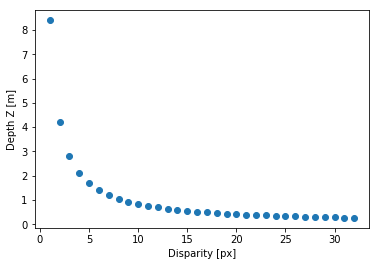

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import cv2

def plot_relation_disparity_depth(f = 300, T_X = 0.10, max_disp = 64):
    """ Focal length f is in pixels, T_X is in meters, max_disp is in pixels.
    """
    
    step_disp = 1;
    disparities = np.arange(1, max_disp+1, step_disp);
    depths = np.zeros(len(disparities));
    i = 0;
    for disp in disparities:
        depths[i] = f * (T_X / disp);
        i += 1;
    
    plt.figure();
    plt.plot(disparities, depths, 'o');
    plt.xlabel('Disparity [px]')
    plt.ylabel('Depth Z [m]')

plot_relation_disparity_depth(f = 140, T_X = 0.06, max_disp = 32)

## The simplest stereo vision algorithm
Although the basic concept sounds easy enough, currently stereo vision is still a very active research area. There are multiple challenges to stereo vision, and there is an ongoing effort to make stereo vision algorithms more accurate and computationally more efficient. If you are interested in some of the latest algorithms and results, please see popular benchmarks such as [Middlebury](http://vision.middlebury.edu/stereo/eval3/) and [KITTI](http://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo). 

In this Jupyter notebook, we will first focus on developing some intuition for what challenges stereo vision involves. To do that, we start with the simplest possible algorithm. We apply our algorithm to two stereo images obtained with the 4-gram stereo vision system that we used to make the 20-gram flapping wing robot _DelFly Explorer_ fly completely by itself.

<img src="DelFly_Explorer.jpg" width="300" alt="DelFly Explorer"/>
<center><small>The <I>DelFly Explorer</I>, described in <A HREF="https://www.researchgate.net/profile/Guido_Croon/publication/266394748_Autonomous_Flight_of_a_20-gram_Flapping_Wing_MAV_with_a_4-gram_Onboard_Stereo_Vision_System/links/550b28780cf265693cef6b3d.pdf" TARGET="_blank">De Wagter, C. et al. Autonomous flight of a 20-gram flapping wing mav with a 4-gram onboard stereo vision system. In the 2014 IEEE International Conference on Robotics and Automation (ICRA),  (pp. 4982-4987)</A>.</small></center>

<img alt="Stereo image from DelFly Explorer" src=" stereo_image_explorer.bmp"/>
<center><small>Stereo images we will be working with.</small></center>

Now, let us first import some necessary libraries and the function that will read the stereo image and separate the left and right image.



In [2]:
def read_stereo_image(im="stereo_image_explorer.bmp"):
    cv_im = cv2.imread(im);
    imgL = cv_im[0:96, 126:252, :];
    imgR = cv_im[0:96, 0:126, :];
    return [imgL, imgR]

# read the image:
[imgL, imgR] = read_stereo_image();

We have now read the left and right image. The following code will show them inline.

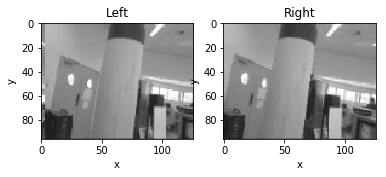

In [3]:
# show the images
plt.figure();
plt.subplot(121)
plt.imshow(imgL);
plt.xlabel('x');
plt.ylabel('y');
plt.title('Left');

plt.subplot(122)
plt.imshow(imgR);
plt.xlabel('x');
plt.ylabel('y');
plt.title('Right');

Now it is time for the simplest stereo vision algorithm. For each pixel in the left image, at location $(x, y)$, search the corresponding pixel in the right image by looking at the image intensity of a single pixel. So, the pixel intensity in the left image is $I_l(x,y)$. The algorithm then starts at $(x,y)$ in the right image and then moves more and more to the left. In other words, the algorithm looks at the intensity in the right image $I_r(x-d, y)$, for the disparity $d$ in a given fixed range $[0, D]$. The absolute difference between the pixel intensities, $|I_l(x,y) - I_r(x-d, y)|$ is stored for all disparities $d$, and the disparity resulting in the minimal absolute difference is selected as the correct disparity. This disparity is stored in the disparity image.

<small>Small question: why does the algorithm not also have to check for coordinates to the _right_ of $(x,y)$, i.e., $(x+i,y)$, for various $i$?</small>

In [4]:
def simple_stereo(imgL, imgR, max_disparity=30):
    
    W = imgL.shape[1];
    H = imgL.shape[0];
    
    # create the disparities image:
    Disparities = np.zeros([H, W]);
    
    # loop over the image
    for x in range(W):
        
        # in the left border of the left image, not all disparities can be investigated:
        max_disp = np.min([x, max_disparity]);
        disps = np.arange(0, max_disp+1);
        
        for y in range(H):
            # we can determine the differences in one go:
            differences = np.abs(imgL[y,x,0] - imgR[y, x-max_disp:x+1,0]);
            differences = differences[::-1];
            # the minimal difference determines the disparity
            disp_ind = np.argmin(differences);
            disparity = disps[disp_ind];
            Disparities[y, x] = disparity;
    
    return Disparities;


If you have familiarized yourself with the above code, please run it to see what the effect is.

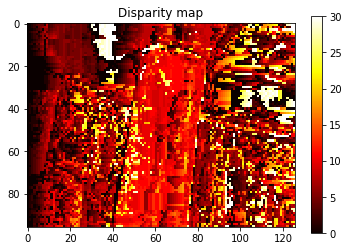

In [5]:
D = simple_stereo(imgL, imgR, max_disparity = 30);

plt.figure();
plt.imshow(D, cmap='hot');
plt.colorbar();
plt.title('Disparity map');
plt.draw()

Bright, yellow areas are close by, while dark areas are far away. There are many areas in the image that have a wrong disparity in the image. There are many reasons for this suboptimal result. One reason may be that 30 is quite a large value for the maximum disparity, enhancing the probability that there is a similar pixel for a 'wrong' disparity value. 

<font color="red"><B>Exercise 2.</B></font>

1. What happens for a very small value, like `max_disparity` = 1? Is it a good disparity map? Why / why not?
2. What happens for a very big value, like `max_disparity` = 100? Is it a good disparity map? Why / why not?
3. Please change the maximum disparity in the cell above and rerun the script to see if you can get a better result.
4. Looking at the code, what is the effect on computational effort when you increase the maximum disparity? Does a possible change in computational effort depend on the image size? If yes, how?

One can also get insight into the errors by investigating what the differences array looks like from which the best disparity is chosen. The following code will allow us to select an image coordinate $(x,y)$ in the left image, and show the according differences array.

In [6]:
def get_differences_curve(imgL, imgR, x, y, max_disparity=30):
    
    # determine the disparities that will be investigated:
    max_disp = np.min([x, max_disparity]); # make sure that we will not investigate negative indices
    disps = np.arange(0, max_disp+1);
    
    # we can determine the differences in one go:
    differences = np.abs(imgL[y,x,0] - imgR[y, x-max_disp:x+1,0]);
    differences = differences[::-1];
    # the minimal difference determines the disparity
    disp_ind = np.argmin(differences);
    disparity = disps[disp_ind];
    
    return [differences, disps, disp_ind];

<font color="red"><b>Exercise 3.</b></font>

Run the code below. The first coordinate $(x,y) = (48, 64)$ already shows a big problem, which is the existence of multiple minima. Try changing the coordinate to find other apparent problems for the automatic selection of the best disparity. Please stay in bounds of the image - the code is not that smart... We do print the size of the image above: $126 \times 96$ pixels. Note that Python's indexing starts at 0 and that $(0,0)$ is the top left of the image.

1. What happens when you select a coordinate in a uniform area?
2. What happens when you select a coordinate in an occluded area, i.e., one that is visible in the left image but not in the right image?

Image size, width = 126, height = 96


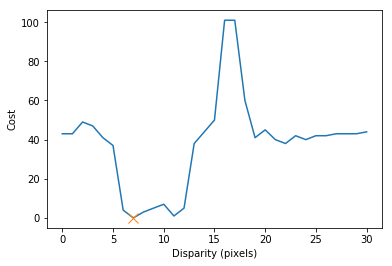

In [7]:
print('Image size, width = {}, height = {}'.format(imgL.shape[1], imgL.shape[0]))
[differences, disps, disp_ind] = get_differences_curve(imgL, imgR, x=40, y=60); 
plt.figure();
plt.plot(disps, differences);
plt.plot(disps[disp_ind], differences[disp_ind], 'x', markersize=10);
plt.xlabel('Disparity (pixels)')
plt.ylabel('Cost')
plt.draw();

## Window-based matching
A major reason for the wrong results above is that a single pixel is a very poor basis for matching between images. A given pixel value may occur in many different regions of the image, also on a single scan line. The next simplest stereo vision algorithm acknowledges this fact, and hence focuses on the differences between pixels in a window centered on $(x,y)$ and $(x-d, y)$. Now, we do not just take the absolute difference in intensity at a single pixel, but in the entire window:

SAD $= \sum_{i=-C}^C \sum_{j=-C}^C \left| I_l(x+i, y+j) - I_r(x+i-d, y+j) \right| $,

where SAD stands for the Sum of Absolute Differences, and serves as the new 'difference' value, and the window size is $2C+1$. 

The algorithm is given below:

In [8]:
def windowed_stereo(imgL, imgR, max_disparity=30, window_half_size=3):
    
    W = imgL.shape[1];
    H = imgL.shape[0];
    
    # create the disparities image:
    Disparities = np.zeros([H, W]);
    
    # loop over the image
    for x in np.arange(window_half_size, W-window_half_size):
        
        # in the left border of the left image, not all disparities can be investigated:
        max_disp = np.min([x-window_half_size, max_disparity]);
        if(max_disp >= 0):
            disps = np.arange(0, max_disp+1);
            differences = np.zeros([len(disps), 1]);
            
            for y in np.arange(window_half_size, H-window_half_size):
                
                window_left = imgL[y-window_half_size:y+window_half_size, x-window_half_size:x+window_half_size, 0];
                
                for d in disps:
                    window_right = imgR[y-window_half_size:y+window_half_size, x-d-window_half_size:x-d+window_half_size, 0];
                    differences[d] = np.sum(np.abs(window_left.astype(float) - window_right.astype(float)));
                
                # the minimal difference determines the disparity
                disp_ind = np.argmin(differences);
                disparity = disps[disp_ind];
                Disparities[y, x] = disparity;
    
    return Disparities;

Now, let's run this algorithm with a max disparity of 30 and half window size $C=3$:

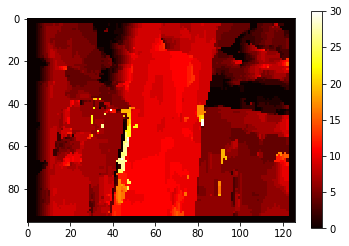

In [9]:
D = windowed_stereo(imgL, imgR, max_disparity=30, window_half_size=3);
plt.figure();
plt.imshow(D, cmap='hot');
plt.colorbar();
plt.draw()

This already looks much better! 

<font color="red"><b>Exercise 4.</b></font>

Play with the maximum disparity and especially with the window size in the code above to see the effects on the disparity map. 

1. Can you get much better results? 
2. What happens when the half window size becomes big, like 8 for example? 

## 'Better' methods
The algorithms just shown for stereo vision are the most elementary ones that can be imagined. The goal above was to let you gain some fundamental insights into stereo vision. Both algorithms above have in common that they only look _locally_ at what the best disparity is. That is, for each coordinate $(x,y)$ they select the disparity with lowest error, without considering certain regularities in the real world. For instance, in the real world, disparities tend to change smoothly when pixels belong to the same object and then may change abruptly when there is an edge of the object. _Global_ methods take such regularities into account, i.e., they make some assumptions on how disparities change over the image and optimize the disparities over the whole image.

Stereo vision algorithms can be better in terms of accuracy, or computational effort, or both. There are is an increasing number of algorithms that satisfies both criteria quite well. A well-known algorithm that is quite efficient and accurate is "Semi-global block matching" - _SGBM_, by Hirschmuller, H. (2008). Stereo processing by semiglobal matching and mutual information. IEEE Transactions on pattern analysis and machine intelligence, 30(2), 328-341.

SGBM is part of openCV and easy to implement in Python:

In [10]:
def calculate_disparities(imgL, imgR, window_size=7, min_disp=0, num_disp=16):
    # semi-global matching:
    stereo = cv2.StereoSGBM_create(numDisparities = num_disp, blockSize = window_size);
    disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0;
    return disp; 

Let us run it on our images:

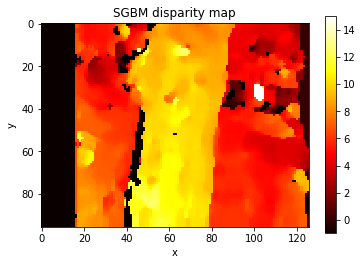

In [11]:
D = calculate_disparities(imgL, imgR, window_size=7, min_disp=0, num_disp=16)
plt.figure();
plt.imshow(D, cmap='hot');
plt.colorbar();
plt.xlabel('x');
plt.ylabel('y');
plt.title('SGBM disparity map');
plt.draw()

This looks good!

<font color="red"><b>Exercise 5.</b></font>

1. Why is there a black bar on the left?  
2. Perhaps you can play with the parameters to get a better result than I did. Watch out: the num_disp parameter apparently has to be a multiple of 16... 

Unfortunately, on the DelFly we only had a processor with 168 MHz and 192 kB of memory... Hence, we had to make a computationally cheaper method...

You can find the code above in the file `stereo_vision.py` <A HREF="https://github.com/guidoAI/stereo_notebook/blob/master/stereo_vision.py" TARGET="_blank">(link to file)</A>.

## Challenges in stereo vision

The following are challenges in stereo vision:
* Uniform (untextured) image regions
* Occlusions
* Low-light conditions (noise)
* Reflections / specularities
* Different camera responses
* Imperfect calibration

<font color="red"><b>Exercise 6.</b></font>
1. Can you indicate for each challenge why it is actually a challenge for stereo vision?

## Answers

Exercise 1.

1. A disparity of 0 means $Z = \infty$
2. It is not so useful, as it would mostly mean that the drone is able to see really _small_ distances. 
3. A bigger baseline distance $T_X$ and a bigger focal length $f$ will allow the system to see further away.
4. The same parameters as for answer 3. If they both become quite large, also ``max_disp`` may need to change to keep a good resolution for the lower distances. Finally, resolution is also really helped by detecting sub-pixel disparities. You can see this by changing ``step_disp = 1;`` to ``step_disp = 0.25;``

Exercise 2. 

1. This does not give good disparity maps. The reason is that in the images, disparities are typically bigger than 1. By setting the max disparity too low, the algorithm excludes these true disparities.
2. Setting the maximum disparity very large increases the chance that the pixel is matched to a pixel on a different world point, just because the intensity is similar despite the pixel corresponding to a different world point. So, in the matching there are many local minima.
3. You cannot really reach a great result with pixel matching...
4. The computational effort is roughly $W \times H \times D_{\textrm{max}}$. So, both the image size and disparity really affect the computation time a lot.

Exercise 3. 

1. In a uniform area, all errors are similar, resulting in quite a flat line, e.g., $(x,y) = (30,10)$.
2. In such an area the errors should all be high. Of course, with pixel matching, there may still be (wrongly) matching pixels. For example, try $(x,y) = (50,40)$.

Exercise 4.

1. Setting ``max_disparity`` to 20 gives better results. 
2. Big window sizes lead to very blurry disparity maps.

Exercise 5.

1. The algorithm does not determine disparities if the x-coordinate is smaller than the max disparity. You can check this by setting the max disparity to 32.
2. The initial settings are actually quite good : )

Exercise 6.

1.
Per factor:
* Uniform image regions: a pixel and its surroundings will have many matches, so it is hard to determine the true disparity. 
* Occlusions: the image patch at the pixel location is simply not visible in the other image, so any match will be faulty.
* Low-light conditions (noise): In low light, cameras will have more noise, which leads to more difficult matching.
* Reflections / specularities: The image location of a reflection / specularity does not depend on the location of the imaged world point but also on the location of the reflected object. A lamp reflected on the floor may appear to be much further away than the floor, and a drone in the mirror will appear to be furher away than the mirror.
* Different camera responses: Different colors / brightness in the two stereo images leads to higher matching errors in general and hence harder matching, as the same world point can have a different appearance.
* Imperfect calibration: Matches may not lie on the same image row or determined disparities may be hard to translate back to actual distances.
